# Config

In [1]:
# # Set dark mode as default
# import matplotlib.pyplot as plt
# import plotly.io as pio

# plt.style.use("dark_background")
# pio.templates.default = "plotly_dark"

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from market_regime.data import get_data, load_params
from market_regime.features import (
    TreeClassifierFeatureBuilder,
    ImageFeatureBuilder,
    SharpeFeatureBuilder,
)
from market_regime.models import XGBTreeModel, CNNModel, SharpeModel
from market_regime.pipelines.base import RegimePipeline
from market_regime.experiment import (
    oos_predict_one_row,
    oos_predict_with_tail,
    baseline_prev_label,
    baseline_freq_sampler,
    evaluate_predictions,
    print_eval,
)

# Data

In [2]:
# Data import (with labels)
df = get_data()

In [3]:
# Load best params
best_params_xgb = load_params("best_params_xgb")
best_params_arch = load_params("best_params_arch")
best_params_arch_k = load_params("best_params_arch_k")

# Experiment

In [ ]:
H = 20
W = 60
INIT_TRAIN_END = df[df["delivery_date"] < "2019-01-01"].index[-1]
OOS_START = df[df["delivery_date"] >= "2019-01-01"].index[0]
MIN_HIST_XGB = 300
MIN_HIST_CNN = W - 1

# XGB
rp_xgb = RegimePipeline(
    feature_builder=TreeClassifierFeatureBuilder(),
    estimator=XGBTreeModel(**best_params_xgb),
)
pred_xgb = oos_predict_with_tail(
    df,
    rp_xgb,
    oos_start=OOS_START,
    min_history_days=MIN_HIST_XGB,
    label_horizon=H,
    desc="OOS XGB",
)

# CNN
rp_cnn = RegimePipeline(
    feature_builder=ImageFeatureBuilder(),
    estimator=CNNModel(
        lr=1e-4,
        epochs=30,
        patience=7,
        balanced_batches=True,
        early_stop_metric="macro_f1",
        seed=333,
    ),
)
pred_cnn = oos_predict_with_tail(
    df,
    rp_cnn,
    oos_start=OOS_START,
    min_history_days=MIN_HIST_CNN,
    label_horizon=H,
    desc="OOS CNN",
)


# ARCH (bez k)
rp_arch_nok = RegimePipeline(
    feature_builder=SharpeFeatureBuilder(),
    estimator=SharpeModel(**best_params_arch),
)
pred_arch_nok = oos_predict_one_row(
    df, rp_arch_nok, oos_start=OOS_START, desc="OOS ARCH (no-k)"
)

# ARCH (z k)
rp_arch_k = RegimePipeline(
    feature_builder=SharpeFeatureBuilder(),
    estimator=SharpeModel(**best_params_arch_k),
)
pred_arch_k = oos_predict_one_row(
    df, rp_arch_k, oos_start=OOS_START, desc="OOS ARCH (with-k)"
)

# Baselines (poprzedni label / losowanie z zaobserwowanej probki)
pred_base_prev = baseline_prev_label(
    df,
    oos_start=OOS_START,
    init_train_end=INIT_TRAIN_END,
    label_horizon=H,
)
pred_base_freq = baseline_freq_sampler(
    df,
    oos_start=OOS_START,
    init_train_end=INIT_TRAIN_END,
    label_horizon=H,
    seed=333,
    smoothing=1.0,
)

OOS CNN:   0%|          | 0/1537 [00:00<?, ?it/s]

In [54]:
preds = {
    "baseline_prev": pred_base_prev,
    "baseline_freq": pred_base_freq,
    "xgb": pred_xgb,
    "cnn": pred_cnn,
    "arch_no_k": pred_arch_nok,
    "arch_with_k": pred_arch_k,
}

# wspólne daty (bez NaN)
common_idx = None
for s in preds.values():
    idx = s.dropna().index
    common_idx = idx if common_idx is None else common_idx.intersection(idx)

common_idx = common_idx.sort_values()
print("Common evaluation window:", common_idx.min(), "->", common_idx.max(), "n=", len(common_idx))

preds_common = {k: v.reindex(common_idx) for k, v in preds.items()}

Common evaluation window: 2018-11-30 00:00:00 -> 2024-11-28 00:00:00 n= 1537


In [ ]:
# # save predictions
# for pred_name, pred_values in preds.items():
#     pred_values.to_pickle(f"{pred_name}.pickle")

In [55]:
evals = {}
for name, ser in preds_common.items():
    evals[name] = evaluate_predictions(df, ser, name=name)

# tabela zbiorcza
summary_df = pd.DataFrame([
    {
        "model": name,
        "n": e["n"],
        "macro_f1": e["macro_f1"],
        "balanced_acc": e["balanced_acc"],
    }
    for name, e in evals.items()
]).sort_values("macro_f1", ascending=False)

display(summary_df)

# opcjonalnie: wydruk szczegółów dla każdego
for name, e in evals.items():
    print_eval(e)

,model,n,macro_f1,balanced_acc
0,baseline_prev,1537,0.423016,0.422673
3,cnn,1537,0.371590,0.390499
2,xgb,1537,0.343711,0.342569
1,baseline_freq,1537,0.313477,0.313711
4,arch_no_k,1537,0.161726,0.332656
5,arch_with_k,1537,0.161656,0.333333



=== baseline_prev ===
n = 1537
macro_f1        = 0.4230
balanced_acc    = 0.4227

Confusion matrix:
         pred_-1  pred_0  pred_1
true_-1      319     194     102
true_0       184     165     143
true_1       112     140     178

Class distribution:
y_true:
 target
-1    0.400130
 0    0.320104
 1    0.279766
Name: proportion, dtype: float64

y_pred:
 prediction
-1    0.400130
 0    0.324658
 1    0.275211
Name: proportion, dtype: float64

Classification report:
               precision    recall  f1-score   support

          -1       0.52      0.52      0.52       615
           0       0.33      0.34      0.33       492
           1       0.42      0.41      0.42       430

    accuracy                           0.43      1537
   macro avg       0.42      0.42      0.42      1537
weighted avg       0.43      0.43      0.43      1537


=== baseline_freq ===
n = 1537
macro_f1        = 0.3135
balanced_acc    = 0.3137

Confusion matrix:
         pred_-1  pred_0  pred_1
true_-1      

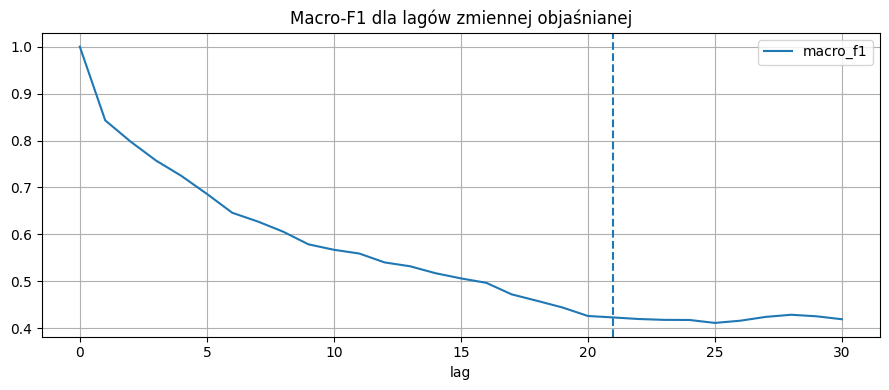

In [ ]:
# summary_df["lag"] = summary_df["model"].str.split("_").apply(lambda x: x[-1]).astype(int)
# plt.figure(figsize=(9, 4))
# sns.lineplot(data=summary_df.set_index("lag")[["macro_f1"]].sort_index())

# plt.axvline(21, linestyle="--")   # pionowa przerywana linia przy lag=21
# plt.grid(True)

# plt.title("Macro-F1 dla lagów zmiennej objaśnianej")
# plt.xlabel("lag")
# # plt.ylabel("macro_f1")
# plt.tight_layout()